In [1]:
import tensorflow as tf
from tensorflow import keras

import os
import tempfile

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [2]:
mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [3]:
file = tf.keras.utils
raw_df = pd.read_csv('https://storage.googleapis.com/download.tensorflow.org/data/creditcard.csv')
raw_df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [4]:
raw_df[['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V26', 'V27', 'V28', 'Amount', 'Class']].describe()

,Time,V1,V2,V3,V4,V5,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [5]:
neg, pos = np.bincount(raw_df['Class'])
total = neg + pos
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

Examples:
    Total: 284807
    Positive: 492 (0.17% of total)



In [6]:
cleaned_df = raw_df.copy()

# You don't want the `Time` column.
cleaned_df.pop('Time')

# The `Amount` column covers a huge range. Convert to log-space.
eps = 0.001 # 0 => 0.1¢
cleaned_df['Log Amount'] = np.log(cleaned_df.pop('Amount')+eps)

In [7]:
# Use a utility from sklearn to split and shuffle your dataset.
train_df, test_df = train_test_split(cleaned_df, test_size=0.2)
train_df, val_df = train_test_split(train_df, test_size=0.2)

# Form np arrays of labels and features.
train_labels = np.array(train_df.pop('Class'))
bool_train_labels = train_labels != 0
val_labels = np.array(val_df.pop('Class'))
test_labels = np.array(test_df.pop('Class'))

train_features = np.array(train_df)
val_features = np.array(val_df)
test_features = np.array(test_df)

In [8]:
scaler = StandardScaler()
train_features = scaler.fit_transform(train_features)

val_features = scaler.transform(val_features)
test_features = scaler.transform(test_features)

train_features = np.clip(train_features, -5, 5)
val_features = np.clip(val_features, -5, 5)
test_features = np.clip(test_features, -5, 5)


print('Training labels shape:', train_labels.shape)
print('Validation labels shape:', val_labels.shape)
print('Test labels shape:', test_labels.shape)

print('Training features shape:', train_features.shape)
print('Validation features shape:', val_features.shape)
print('Test features shape:', test_features.shape)

Training labels shape: (182276,)
Validation labels shape: (45569,)
Test labels shape: (56962,)
Training features shape: (182276, 29)
Validation features shape: (45569, 29)
Test features shape: (56962, 29)


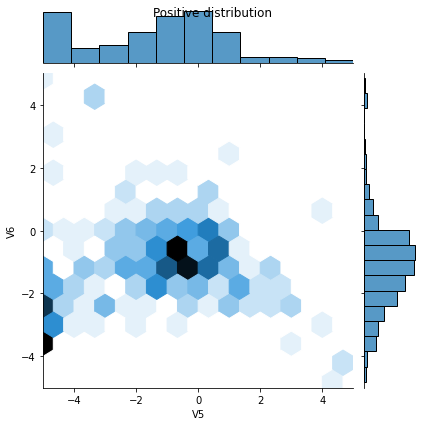

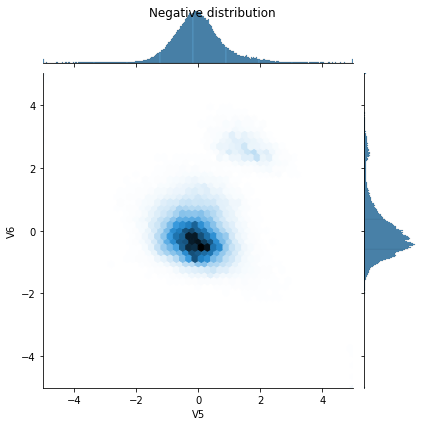

In [9]:
pos_df = pd.DataFrame(train_features[ bool_train_labels], columns=train_df.columns)
neg_df = pd.DataFrame(train_features[~bool_train_labels], columns=train_df.columns)

sns.jointplot(x=pos_df['V5'], y=pos_df['V6'],
              kind='hex', xlim=(-5,5), ylim=(-5,5))
plt.suptitle("Positive distribution")

sns.jointplot(x=neg_df['V5'], y=neg_df['V6'],
              kind='hex', xlim=(-5,5), ylim=(-5,5))
_ = plt.suptitle("Negative distribution")

In [10]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

def make_model(metrics=METRICS, output_bias=None):
  if output_bias is not None:
    output_bias = tf.keras.initializers.Constant(output_bias)
  model = keras.Sequential([
      keras.layers.Dense(
          16, activation='relu',
          input_shape=(train_features.shape[-1],)),
      keras.layers.Dropout(0.5),
      keras.layers.Dense(1, activation='sigmoid',
                         bias_initializer=output_bias),
  ])

  model.compile(
      optimizer=keras.optimizers.Adam(learning_rate=1e-3),
      loss=keras.losses.BinaryCrossentropy(),
      metrics=metrics)

  return model

Metal device set to: Apple M1 Pro


2022-07-24 23:41:58.067668: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-07-24 23:41:58.067797: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [11]:
EPOCHS = 100
BATCH_SIZE = 2048

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_prc', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)

In [12]:
model = make_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16)                480       
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 497
Trainable params: 497
Non-trainable params: 0
_________________________________________________________________


In [13]:
model.predict(train_features[:10])

1/1 [==============================] - 0s 44ms/step


2022-07-24 23:41:58.168914: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-07-24 23:41:58.196233: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


array([[0.3318802 ],
       [0.27018726],
       [0.15906529],
       [0.3773457 ],
       [0.2517921 ],
       [0.2187418 ],
       [0.1995801 ],
       [0.41356   ],
       [0.42683348],
       [0.13311535]], dtype=float32)

In [14]:
results = model.evaluate(train_features, train_labels, batch_size=BATCH_SIZE, verbose=0)
print("Loss: {:0.4f}".format(results[0]))

2022-07-24 23:41:58.646829: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Loss: 0.4279


In [15]:
initial_bias = np.log([pos/neg])
initial_bias

array([-6.35935934])

In [16]:
model = make_model(output_bias=initial_bias)
model.predict(train_features[:10])

1/1 [==============================] - 0s 28ms/step


2022-07-24 23:42:29.307685: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


array([[0.00292682],
       [0.00157384],
       [0.00095934],
       [0.0040292 ],
       [0.00389382],
       [0.00074741],
       [0.00073578],
       [0.00761636],
       [0.00209025],
       [0.00139068]], dtype=float32)

In [17]:
results = model.evaluate(train_features, train_labels, batch_size=BATCH_SIZE, verbose=0)
print("Loss: {:0.4f}".format(results[0]))

2022-07-24 23:42:36.092138: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Loss: 0.0151


In [18]:
initial_weights = os.path.join(tempfile.mkdtemp(), 'initial_weights')
model.save_weights(initial_weights)

In [19]:
model = make_model()
model.load_weights(initial_weights)
model.layers[-1].bias.assign([0.0])
zero_bias_history = model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=20,
    validation_data=(val_features, val_labels), 
    verbose=0)

2022-07-24 23:43:30.836909: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-24 23:43:32.783097: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [20]:
model = make_model()
model.load_weights(initial_weights)
careful_bias_history = model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=20,
    validation_data=(val_features, val_labels), 
    verbose=0)

2022-07-24 23:44:09.855413: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-24 23:44:11.783522: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [21]:
def plot_loss(history, label, n):
  # Use a log scale on y-axis to show the wide range of values.
  plt.semilogy(history.epoch, history.history['loss'],
               color=colors[n], label='Train ' + label)
  plt.semilogy(history.epoch, history.history['val_loss'],
               color=colors[n], label='Val ' + label,
               linestyle="--")
  plt.xlabel('Epoch')
  plt.ylabel('Loss')

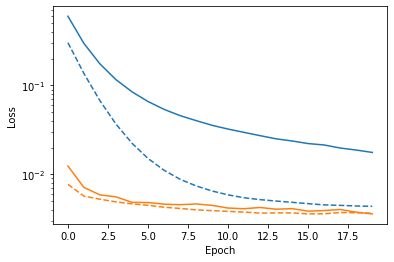

In [22]:
plot_loss(zero_bias_history, "Zero Bias", 0)
plot_loss(careful_bias_history, "Careful Bias", 1)

In [23]:
model = make_model()
model.load_weights(initial_weights)
baseline_history = model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[early_stopping],
    validation_data=(val_features, val_labels))

Epoch 1/100


2022-07-24 23:47:27.068821: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


90/90 [==============================] - ETA: 0s - loss: 0.0123 - tp: 79.0000 - fp: 22.0000 - tn: 227441.0000 - fn: 303.0000 - accuracy: 0.9986 - precision: 0.7822 - recall: 0.2068 - auc: 0.7433 - prc: 0.2509

2022-07-24 23:47:29.400075: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


90/90 [==============================] - 4s 30ms/step - loss: 0.0123 - tp: 79.0000 - fp: 22.0000 - tn: 227441.0000 - fn: 303.0000 - accuracy: 0.9986 - precision: 0.7822 - recall: 0.2068 - auc: 0.7433 - prc: 0.2509 - val_loss: 0.0076 - val_tp: 14.0000 - val_fp: 4.0000 - val_tn: 45486.0000 - val_fn: 65.0000 - val_accuracy: 0.9985 - val_precision: 0.7778 - val_recall: 0.1772 - val_auc: 0.8713 - val_prc: 0.5749
Epoch 2/100
90/90 [==============================] - 2s 22ms/step - loss: 0.0070 - tp: 120.0000 - fp: 21.0000 - tn: 181952.0000 - fn: 183.0000 - accuracy: 0.9989 - precision: 0.8511 - recall: 0.3960 - auc: 0.8687 - prc: 0.5386 - val_loss: 0.0056 - val_tp: 39.0000 - val_fp: 7.0000 - val_tn: 45483.0000 - val_fn: 40.0000 - val_accuracy: 0.9990 - val_precision: 0.8478 - val_recall: 0.4937 - val_auc: 0.8984 - val_prc: 0.6516
Epoch 3/100
90/90 [==============================] - 2s 23ms/step - loss: 0.0061 - tp: 157.0000 - fp: 28.0000 - tn: 181945.0000 - fn: 146.0000 - accuracy: 0.9990 - p

Epoch 38: early stopping


In [24]:
def plot_metrics(history):
  metrics = ['loss', 'prc', 'precision', 'recall']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend();

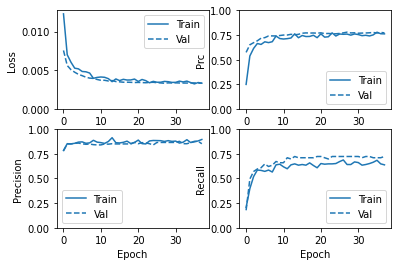

In [25]:
plot_metrics(baseline_history)

In [26]:
train_predictions_baseline = model.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_baseline = model.predict(test_features, batch_size=BATCH_SIZE)

 1/28 [>.............................] - ETA: 0s

2022-07-24 23:52:50.498359: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


28/28 [==============================] - 0s 2ms/step


In [27]:
def plot_cm(labels, predictions, p=0.5):
  cm = confusion_matrix(labels, predictions > p)
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title('Confusion matrix @{:.2f}'.format(p))
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

  print('Legitimate Transactions Detected (True Negatives): ', cm[0][0])
  print('Legitimate Transactions Incorrectly Detected (False Positives): ', cm[0][1])
  print('Fraudulent Transactions Missed (False Negatives): ', cm[1][0])
  print('Fraudulent Transactions Detected (True Positives): ', cm[1][1])
  print('Total Fraudulent Transactions: ', np.sum(cm[1]))

loss :  0.0027907195035368204
tp :  92.0
fp :  13.0
tn :  56839.0
fn :  18.0
accuracy :  0.9994557499885559
precision :  0.8761904835700989
recall :  0.836363673210144
auc :  0.9452013969421387
prc :  0.8502739667892456

Legitimate Transactions Detected (True Negatives):  56839
Legitimate Transactions Incorrectly Detected (False Positives):  13
Fraudulent Transactions Missed (False Negatives):  18
Fraudulent Transactions Detected (True Positives):  92
Total Fraudulent Transactions:  110


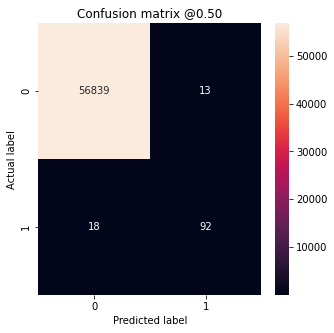

In [28]:
baseline_results = model.evaluate(test_features, test_labels,
                                  batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(model.metrics_names, baseline_results):
  print(name, ': ', value)
print()

plot_cm(test_labels, test_predictions_baseline)

In [29]:
def plot_roc(name, labels, predictions, **kwargs):
  fp, tp, _ = sklearn.metrics.roc_curve(labels, predictions)

  plt.plot(100*fp, 100*tp, label=name, linewidth=2, **kwargs)
  plt.xlabel('False positives [%]')
  plt.ylabel('True positives [%]')
  plt.xlim([-0.5,20])
  plt.ylim([80,100.5])
  plt.grid(True)
  ax = plt.gca()
  ax.set_aspect('equal')

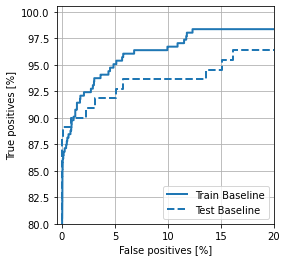

In [30]:
plot_roc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_roc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')
plt.legend(loc='lower right');

In [31]:
def plot_prc(name, labels, predictions, **kwargs):
    precision, recall, _ = sklearn.metrics.precision_recall_curve(labels, predictions)

    plt.plot(precision, recall, label=name, linewidth=2, **kwargs)
    plt.xlabel('Precision')
    plt.ylabel('Recall')
    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect('equal')

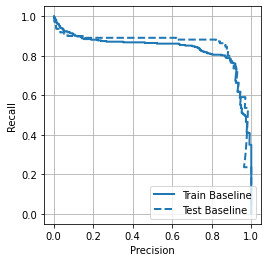

In [32]:
plot_prc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_prc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')
plt.legend(loc='lower right');

In [33]:
# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
weight_for_0 = (1 / neg) * (total / 2.0)
weight_for_1 = (1 / pos) * (total / 2.0)

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 0.50
Weight for class 1: 289.44


In [40]:
weighted_model = make_model()
weighted_model.load_weights(initial_weights)

weighted_history = weighted_model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[early_stopping],
    validation_data=(val_features, val_labels),
    # The class weights go here
    class_weight=class_weight)

Epoch 1/100


2022-07-25 00:02:27.954836: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


90/90 [==============================] - ETA: 0s - loss: 2.3703 - tp: 130.0000 - fp: 98.0000 - tn: 238727.0000 - fn: 283.0000 - accuracy: 0.9984 - precision: 0.5702 - recall: 0.3148 - auc: 0.7607 - prc: 0.3130

2022-07-25 00:02:30.224944: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


90/90 [==============================] - 4s 29ms/step - loss: 2.3703 - tp: 130.0000 - fp: 98.0000 - tn: 238727.0000 - fn: 283.0000 - accuracy: 0.9984 - precision: 0.5702 - recall: 0.3148 - auc: 0.7607 - prc: 0.3130 - val_loss: 0.0087 - val_tp: 32.0000 - val_fp: 8.0000 - val_tn: 45482.0000 - val_fn: 47.0000 - val_accuracy: 0.9988 - val_precision: 0.8000 - val_recall: 0.4051 - val_auc: 0.8812 - val_prc: 0.5729
Epoch 2/100
90/90 [==============================] - 2s 20ms/step - loss: 0.8553 - tp: 177.0000 - fp: 309.0000 - tn: 181664.0000 - fn: 126.0000 - accuracy: 0.9976 - precision: 0.3642 - recall: 0.5842 - auc: 0.8809 - prc: 0.4581 - val_loss: 0.0104 - val_tp: 55.0000 - val_fp: 11.0000 - val_tn: 45479.0000 - val_fn: 24.0000 - val_accuracy: 0.9992 - val_precision: 0.8333 - val_recall: 0.6962 - val_auc: 0.9011 - val_prc: 0.6429
Epoch 3/100
90/90 [==============================] - 2s 20ms/step - loss: 0.6577 - tp: 203.0000 - fp: 644.0000 - tn: 181329.0000 - fn: 100.0000 - accuracy: 0.9959

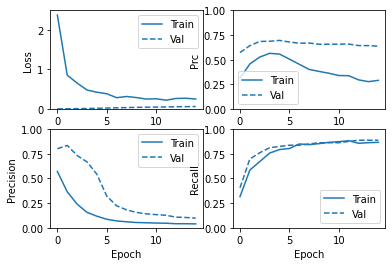

In [41]:
plot_metrics(weighted_history)

In [42]:
train_predictions_weighted = weighted_model.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_weighted = weighted_model.predict(test_features, batch_size=BATCH_SIZE)

 1/28 [>.............................] - ETA: 0s

2022-07-25 00:03:15.465357: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


28/28 [==============================] - 0s 2ms/step


loss :  0.0232783704996109
tp :  97.0
fp :  77.0
tn :  56775.0
fn :  13.0
accuracy :  0.998420000076294
precision :  0.5574712753295898
recall :  0.8818182349205017
auc :  0.9592414498329163
prc :  0.7481796741485596

Legitimate Transactions Detected (True Negatives):  56775
Legitimate Transactions Incorrectly Detected (False Positives):  77
Fraudulent Transactions Missed (False Negatives):  13
Fraudulent Transactions Detected (True Positives):  97
Total Fraudulent Transactions:  110


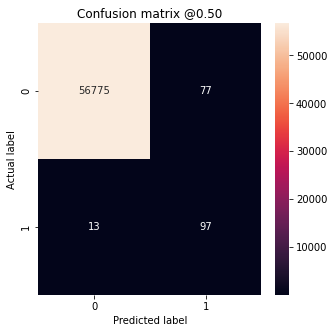

In [43]:
weighted_results = weighted_model.evaluate(test_features, test_labels,
                                           batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(weighted_model.metrics_names, weighted_results):
  print(name, ': ', value)
print()

plot_cm(test_labels, test_predictions_weighted)

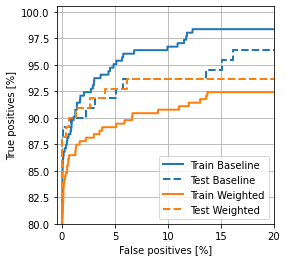

In [44]:
plot_roc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_roc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')

plot_roc("Train Weighted", train_labels, train_predictions_weighted, color=colors[1])
plot_roc("Test Weighted", test_labels, test_predictions_weighted, color=colors[1], linestyle='--')


plt.legend(loc='lower right');

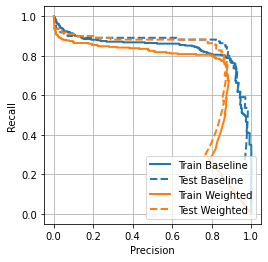

In [45]:
plot_prc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_prc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')

plot_prc("Train Weighted", train_labels, train_predictions_weighted, color=colors[1])
plot_prc("Test Weighted", test_labels, test_predictions_weighted, color=colors[1], linestyle='--')


plt.legend(loc='lower right');

In [46]:
pos_features = train_features[bool_train_labels]
neg_features = train_features[~bool_train_labels]

pos_labels = train_labels[bool_train_labels]
neg_labels = train_labels[~bool_train_labels]

In [47]:
ids = np.arange(len(pos_features))
choices = np.random.choice(ids, len(neg_features))

res_pos_features = pos_features[choices]
res_pos_labels = pos_labels[choices]

res_pos_features.shape

(181973, 29)

In [59]:
resampled_features = np.concatenate([res_pos_features, neg_features], axis=0)
resampled_labels = np.concatenate([res_pos_labels, neg_labels], axis=0)

order = np.arange(len(resampled_labels))
np.random.shuffle(order)
resampled_features = resampled_features[order]
resampled_labels = resampled_labels[order]

resampled_features.shape

In [60]:
BUFFER_SIZE = 100000

def make_ds(features, labels):
  ds = tf.data.Dataset.from_tensor_slices((features, labels))#.cache()
  ds = ds.shuffle(BUFFER_SIZE).repeat()
  return ds

pos_ds = make_ds(pos_features, pos_labels)
neg_ds = make_ds(neg_features, neg_labels)

In [61]:
for features, label in pos_ds.take(1):
  print("Features:\n", features.numpy())
  print()
  print("Label: ", label.numpy())

Features:
 [-1.15924002  1.44313518 -1.95648414  0.06400719 -2.05421954 -0.63159559
 -0.14184334 -0.34372872  0.15930575 -2.76662287  2.55482098 -3.69603504
 -0.96542373 -4.84438938  2.12423019 -4.78238958 -5.         -3.05353437
  1.9538365  -0.63864698  0.34754928 -0.64324217  0.47395942  0.39997529
 -2.46095003 -2.3271217  -1.57970102  0.99021259  1.38231678]

Label:  1


In [62]:
resampled_ds = tf.data.Dataset.sample_from_datasets([pos_ds, neg_ds], weights=[0.5, 0.5])
resampled_ds = resampled_ds.batch(BATCH_SIZE).prefetch(2)

In [63]:
for features, label in resampled_ds.take(1):
  print(label.numpy().mean())

0.4951171875


In [64]:
resampled_steps_per_epoch = np.ceil(2.0*neg/BATCH_SIZE)
resampled_steps_per_epoch

278.0

In [65]:
resampled_model = make_model()
resampled_model.load_weights(initial_weights)

# Reset the bias to zero, since this dataset is balanced.
output_layer = resampled_model.layers[-1] 
output_layer.bias.assign([0])

val_ds = tf.data.Dataset.from_tensor_slices((val_features, val_labels)).cache()
val_ds = val_ds.batch(BATCH_SIZE).prefetch(2) 

resampled_history = resampled_model.fit(
    resampled_ds,
    epochs=EPOCHS,
    steps_per_epoch=resampled_steps_per_epoch,
    callbacks=[early_stopping],
    validation_data=val_ds)

Epoch 1/100


2022-07-25 00:12:08.081696: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


276/278 [============================>.] - ETA: 0s - loss: 0.4731 - tp: 235258.0000 - fp: 87318.0000 - tn: 252094.0000 - fn: 47540.0000 - accuracy: 0.7833 - precision: 0.7293 - recall: 0.8319 - auc: 0.8892 - prc: 0.9088

2022-07-25 00:12:14.114830: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


278/278 [==============================] - 7s 23ms/step - loss: 0.4716 - tp: 237104.0000 - fp: 87541.0000 - tn: 253908.0000 - fn: 47753.0000 - accuracy: 0.7840 - precision: 0.7303 - recall: 0.8324 - auc: 0.8897 - prc: 0.9093 - val_loss: 0.2525 - val_tp: 68.0000 - val_fp: 1240.0000 - val_tn: 44250.0000 - val_fn: 11.0000 - val_accuracy: 0.9725 - val_precision: 0.0520 - val_recall: 0.8608 - val_auc: 0.9715 - val_prc: 0.7149
Epoch 2/100
278/278 [==============================] - 5s 19ms/step - loss: 0.2176 - tp: 258237.0000 - fp: 20476.0000 - tn: 264594.0000 - fn: 26037.0000 - accuracy: 0.9183 - precision: 0.9265 - recall: 0.9084 - auc: 0.9685 - prc: 0.9760 - val_loss: 0.1359 - val_tp: 71.0000 - val_fp: 840.0000 - val_tn: 44650.0000 - val_fn: 8.0000 - val_accuracy: 0.9814 - val_precision: 0.0779 - val_recall: 0.8987 - val_auc: 0.9854 - val_prc: 0.7015
Epoch 3/100
278/278 [==============================] - 6s 20ms/step - loss: 0.1675 - tp: 262796.0000 - fp: 12265.0000 - tn: 271945.0000 - fn

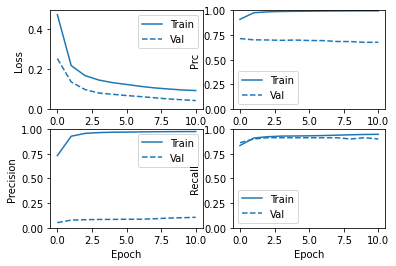

In [66]:
plot_metrics(resampled_history)

In [67]:
resampled_model = make_model()
resampled_model.load_weights(initial_weights)

# Reset the bias to zero, since this dataset is balanced.
output_layer = resampled_model.layers[-1] 
output_layer.bias.assign([0])

resampled_history = resampled_model.fit(
    resampled_ds,
    # These are not real epochs
    steps_per_epoch=20,
    epochs=10*EPOCHS,
    callbacks=[early_stopping],
    validation_data=(val_ds))

Epoch 1/1000


2022-07-25 00:15:54.594685: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


18/20 [==========================>...] - ETA: 0s - loss: 1.1672 - tp: 9030.0000 - fp: 10580.0000 - tn: 53366.0000 - fn: 9457.0000 - accuracy: 0.7569 - precision: 0.4605 - recall: 0.4885 - auc: 0.8032 - prc: 0.5267

2022-07-25 00:15:55.722215: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


20/20 [==============================] - 3s 75ms/step - loss: 1.1431 - tp: 10335.0000 - fp: 11656.0000 - tn: 54265.0000 - fn: 10273.0000 - accuracy: 0.7466 - precision: 0.4700 - recall: 0.5015 - auc: 0.7986 - prc: 0.5438 - val_loss: 0.7805 - val_tp: 50.0000 - val_fp: 23957.0000 - val_tn: 21533.0000 - val_fn: 29.0000 - val_accuracy: 0.4736 - val_precision: 0.0021 - val_recall: 0.6329 - val_auc: 0.6193 - val_prc: 0.0515
Epoch 2/1000
20/20 [==============================] - 1s 33ms/step - loss: 0.7829 - tp: 14349.0000 - fp: 11031.0000 - tn: 9413.0000 - fn: 6167.0000 - accuracy: 0.5801 - precision: 0.5654 - recall: 0.6994 - auc: 0.6797 - prc: 0.7612 - val_loss: 0.7378 - val_tp: 65.0000 - val_fp: 22841.0000 - val_tn: 22649.0000 - val_fn: 14.0000 - val_accuracy: 0.4985 - val_precision: 0.0028 - val_recall: 0.8228 - val_auc: 0.8297 - val_prc: 0.3833
Epoch 3/1000
20/20 [==============================] - 1s 33ms/step - loss: 0.6178 - tp: 16491.0000 - fp: 10213.0000 - tn: 10191.0000 - fn: 4065.0

Epoch 20/1000
20/20 [==============================] - 1s 33ms/step - loss: 0.2239 - tp: 18571.0000 - fp: 1536.0000 - tn: 18964.0000 - fn: 1889.0000 - accuracy: 0.9164 - precision: 0.9236 - recall: 0.9077 - auc: 0.9667 - prc: 0.9748 - val_loss: 0.1812 - val_tp: 71.0000 - val_fp: 867.0000 - val_tn: 44623.0000 - val_fn: 8.0000 - val_accuracy: 0.9808 - val_precision: 0.0757 - val_recall: 0.8987 - val_auc: 0.9808 - val_prc: 0.6974
Epoch 21/1000
20/20 [==============================] - 1s 33ms/step - loss: 0.2169 - tp: 18654.0000 - fp: 1412.0000 - tn: 18997.0000 - fn: 1897.0000 - accuracy: 0.9192 - precision: 0.9296 - recall: 0.9077 - auc: 0.9686 - prc: 0.9762 - val_loss: 0.1736 - val_tp: 71.0000 - val_fp: 859.0000 - val_tn: 44631.0000 - val_fn: 8.0000 - val_accuracy: 0.9810 - val_precision: 0.0763 - val_recall: 0.8987 - val_auc: 0.9817 - val_prc: 0.6973
Epoch 22/1000
20/20 [==============================] - 1s 34ms/step - loss: 0.2076 - tp: 18817.0000 - fp: 1305.0000 - tn: 19001.0000 - fn:

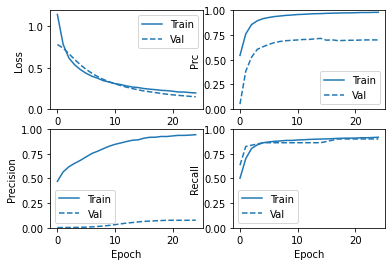

In [68]:
plot_metrics(resampled_history)

In [69]:
train_predictions_resampled = resampled_model.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_resampled = resampled_model.predict(test_features, batch_size=BATCH_SIZE)

 1/28 [>.............................] - ETA: 0s

2022-07-25 00:16:48.464873: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


28/28 [==============================] - 0s 2ms/step


2022-07-25 00:16:53.676684: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


loss :  0.2358357310295105
tp :  99.0
fp :  1386.0
tn :  55466.0
fn :  11.0
accuracy :  0.9754748940467834
precision :  0.06666667014360428
recall :  0.9000000357627869
auc :  0.963302493095398
prc :  0.7751972079277039

Legitimate Transactions Detected (True Negatives):  55466
Legitimate Transactions Incorrectly Detected (False Positives):  1386
Fraudulent Transactions Missed (False Negatives):  11
Fraudulent Transactions Detected (True Positives):  99
Total Fraudulent Transactions:  110


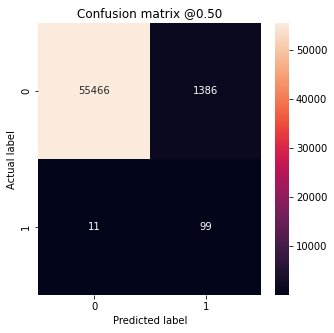

In [70]:
resampled_results = resampled_model.evaluate(test_features, test_labels,
                                             batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(resampled_model.metrics_names, resampled_results):
  print(name, ': ', value)
print()

plot_cm(test_labels, test_predictions_resampled)

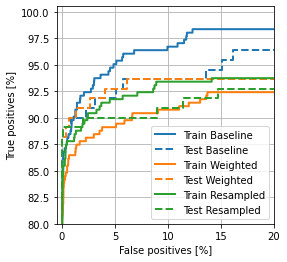

In [72]:
plot_roc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_roc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')

plot_roc("Train Weighted", train_labels, train_predictions_weighted, color=colors[1])
plot_roc("Test Weighted", test_labels, test_predictions_weighted, color=colors[1], linestyle='--')

plot_roc("Train Resampled", train_labels, train_predictions_resampled, color=colors[2])
plot_roc("Test Resampled", test_labels, test_predictions_resampled, color=colors[2], linestyle='--')
plt.legend(loc='lower right');

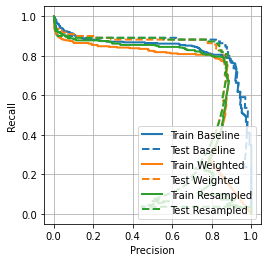

In [73]:
plot_prc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_prc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')

plot_prc("Train Weighted", train_labels, train_predictions_weighted, color=colors[1])
plot_prc("Test Weighted", test_labels, test_predictions_weighted, color=colors[1], linestyle='--')

plot_prc("Train Resampled", train_labels, train_predictions_resampled, color=colors[2])
plot_prc("Test Resampled", test_labels, test_predictions_resampled, color=colors[2], linestyle='--')
plt.legend(loc='lower right');